# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# BUSINESS UNDERSTANDING

Marketing is crucial for the growth and sustainability of the business as it helps build company’s brand, engage customers, grow revenues and increase sales. One of the key painpoint of business is to understand customers and identify their needs in order to tailor campaigns to customer segments most likely to purchase products.
Customer segmentation  helps business plan marketing campaigns easier, focusing on certain customer groups instead of targeting the mass market, therefore more efficient in terms of time, money and other resources. 
* What are the relationship beween demographics of the company's existing customers and the general population of Germany?
* Which parts of the general population that are more likely to be part of the mail-order company's main customer bases, and which parts of the general population are less so
* How historical demographic data can help business to build prediction model, therefore be able to identify potential customers.<br> 

Fortunately, those business questions can be solved using analytics by involving appropriate data analytics tools and methodologies.

# DATA UNDERSTANDING

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import operator
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# load in population data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in customers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Understanding column descriptions and domain values

* load Attributes and Values files
* merge those 2 files to create a data dictionary for Arvato files
* create a list of tuples which contains column name and its 'unknown' domain values
* create a generic function to display the % of missing values in each column

In [18]:
# load Attributes file and fill in missing values for column Information Level
attributes =  pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',sheet_name=None)
attb_desc = list(attributes.values())[0]
attb_desc['Information level'] = attb_desc['Information level'].fillna(method='ffill')
attb_desc.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,Person,ANREDE_KZ,gender,NaN
3,NaN,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [19]:

print('attribute:  {}  description:  {}'.format(attb_desc['Attribute'],attb_desc['Description']))

attribute:  0                         AGER_TYP
1             ALTERSKATEGORIE_GROB
2                        ANREDE_KZ
3                    CJT_GESAMTTYP
4                FINANZ_MINIMALIST
5                    FINANZ_SPARER
6                 FINANZ_VORSORGER
7                   FINANZ_ANLEGER
8            FINANZ_UNAUFFAELLIGER
9                 FINANZ_HAUSBAUER
10                       FINANZTYP
11                     GEBURTSJAHR
12                 GFK_URLAUBERTYP
13                GREEN_AVANTGARDE
14                      HEALTH_TYP
15             LP_LEBENSPHASE_FEIN
16             LP_LEBENSPHASE_GROB
17                 LP_FAMILIE_FEIN
18                 LP_FAMILIE_GROB
19                  LP_STATUS_FEIN
20                  LP_STATUS_GROB
21                NATIONALITAET_KZ
22           PRAEGENDE_JUGENDJAHRE
23                  RETOURTYP_BK_S
24                       SEMIO_SOZ
25                       SEMIO_FAM
26                       SEMIO_REL
27                       SEMIO_MAT
28      

In [20]:
# load Values file and filling missing values for column Attribute
values =  pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name=None)
attb_vals = list(values.values())[0]
attb_vals['Attribute'] = attb_vals['Attribute'].fillna(method='ffill')
attb_vals.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,NaN,0,no classification possible
2,NaN,AGER_TYP,NaN,1,passive elderly
3,NaN,AGER_TYP,NaN,2,cultural elderly
4,NaN,AGER_TYP,NaN,3,experience-driven elderly


In [21]:
# join Attributes and Values files to form data dictionary for Arvato files

data_dictionary = pd.merge(attb_vals, attb_desc, on='Attribute')
data_dictionary = data_dictionary[['Information level','Attribute','Description_x','Value','Meaning','Additional notes']]
data_dictionary

,Information level,Attribute,Description_x,Value,Meaning,Additional notes
0,NaN,AGER_TYP,best-ager typology,-1,unknown,in cooperation with Kantar TNS; the informatio...
1,NaN,AGER_TYP,NaN,0,no classification possible,in cooperation with Kantar TNS; the informatio...
2,NaN,AGER_TYP,NaN,1,passive elderly,in cooperation with Kantar TNS; the informatio...
3,NaN,AGER_TYP,NaN,2,cultural elderly,in cooperation with Kantar TNS; the informatio...
4,NaN,AGER_TYP,NaN,3,experience-driven elderly,in cooperation with Kantar TNS; the informatio...
5,Person,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,modelled on millions of first name-age-referen...
6,Person,ALTERSKATEGORIE_GROB,NaN,1,< 30 years,modelled on millions of first name-age-referen...
7,Person,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years,modelled on millions of first name-age-referen...
8,Person,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years,modelled on millions of first name-age-referen...
9,Person,ALTERSKATEGORIE_GROB,NaN,4,> 60 years,modelled on millions of first name-age-referen...


In [22]:
data_dictionary[data_dictionary['Attribute']=='CJT_GESAMTTYP']

,Information level,Attribute,Description_x,Value,Meaning,Additional notes
128,Person,CJT_GESAMTTYP,customer journey typology,0,unknown,"relating to the preferred information, marketi..."
129,Person,CJT_GESAMTTYP,NaN,1,Advertising- and Consumptionminimalist,"relating to the preferred information, marketi..."
130,Person,CJT_GESAMTTYP,NaN,2,Advertising- and Consumptiontraditionalist,"relating to the preferred information, marketi..."
131,Person,CJT_GESAMTTYP,NaN,3,advertisinginterested Store-shopper,"relating to the preferred information, marketi..."
132,Person,CJT_GESAMTTYP,NaN,4,advertisinginterested Online-shopper,"relating to the preferred information, marketi..."
133,Person,CJT_GESAMTTYP,NaN,5,Advertising- and Cross-Channel-Enthusiast,"relating to the preferred information, marketi..."
134,Person,CJT_GESAMTTYP,NaN,6,Advertising-Enthusiast with restricted Cross-C...,"relating to the preferred information, marketi..."


In [23]:
# display columns and associate values meaning 'unknown'

NaN_meanings = ['unknown','no classification possible','unknown / no main age detectable','no transaction known']
NaN_df = data_dictionary[data_dictionary.Meaning.isin(NaN_meanings)]
NaN_df


,Information level,Attribute,Description_x,Value,Meaning,Additional notes
0,NaN,AGER_TYP,best-ager typology,-1,unknown,in cooperation with Kantar TNS; the informatio...
1,NaN,AGER_TYP,NaN,0,no classification possible,in cooperation with Kantar TNS; the informatio...
5,Person,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,modelled on millions of first name-age-referen...
11,Household,ALTER_HH,main age within the household,0,unknown / no main age detectable,NaN
33,Person,ANREDE_KZ,gender,"-1, 0",unknown,NaN
40,Postcode,BALLRAUM,distance to next urban centre,-1,unknown,NaN
48,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown,New German CAMEO Typology established together...
102,Microcell (RR4_ID),CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown,NaN
128,Person,CJT_GESAMTTYP,customer journey typology,0,unknown,"relating to the preferred information, marketi..."
145,125m x 125m Grid,D19_BANKEN_DIREKT_RZ,transactional activity based on the product gr...,0,no transaction known,AZ has access to approx. 650 Million transacti...


In [24]:
NaN_df['Value'].unique()

array([-1, 0, '-1, 0', '-1, 9', '-1'], dtype=object)

In [25]:
# create a list of tuples which contains column name and associate 'unknown' values
idx = NaN_df.index
unknown_list =[]
for i in idx:
    val = NaN_df['Value'][i]
    if val == '-1, 0' or val == '-1, 9':
        tupl = (NaN_df['Attribute'][i],val[0:2])
        unknown_list.append(tupl)
        tupl = (NaN_df['Attribute'][i],val[4:6])
        unknown_list.append(tupl)
    else:
        tupl = (NaN_df['Attribute'][i],str(val))
        unknown_list.append(tupl)

In [26]:
def check_unknown_value(col,value):
    '''
    This functions check if a value in a column match 'unknown' definition is data dictionary
    INPUT: - a column in a dataset
           - a value in the column
    OUTPUT:
           return true if the value of the column match 'unknown' definition in data dictionary, otherwise return false
    '''
    result = bool()
    tup = (col,value)
    if tup in unknown_list:
        result = True
    else:
        result = False

    return result

def percent_missing_values(df):
    '''
    This function calculate and display % of missing values in each column of dataset
    INPUT: pandas dataframe
    OUTPUT: dictionary with key is the column name and value is % of missing
    '''
    missing_dict = {}
    total_rec = df.shape[0]
    
    for col in df.columns.values:  #iterate columns
        # if column contain NaN values, calculate the mean of missing values
        if df[col].isnull().values.any():  
            missing_dict[col]= df[col].isnull().mean()
        # if column does not contain NaN values, map values to 'unknown' value in data dictionary
        else:
            s = df[col].value_counts(dropna=False)
            nan_count = 0
            for index, value in s.items():        
                if check_unknown_value(col,str(index)) :
                    nan_count = nan_count + value
            missing_dict[col]= round(nan_count/total_rec,4)
            
    # print dictionary in reverse order (highest-> lowest % missing values)
    sorted_d = dict( sorted(missing_dict.items(), key=operator.itemgetter(1),reverse=True))
        
    missing_dict = sorted_d
    
    return missing_dict



In [27]:
def top_percent_missing(df, percent):
    '''
    This function displays and return columns which have % missing greater than certain percentage
    INPUT: - input pandas dataframe
           - percent , enter 50 for 50%
    OUTPUT: a list of columns which have % missing greater than <percent>
    '''
    cols = []
    
    missing_dict = percent_missing_values(df)
    for key,value in missing_dict.items():
        if value > percent/100:
            cols.append(key)
    return cols

### Data Analysis - Population file

In [16]:
# display top5 rows in population file
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [17]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [18]:
# display % of missing in population file
missing_pop = percent_missing_values(azdias)
for key,val in missing_pop.items():
    print('{} - {}'.format(key,val))

ALTER_KIND4 - 0.9986479223447383
ALTER_KIND3 - 0.9930769135826019
ALTER_KIND2 - 0.9669004657655059
ALTER_KIND1 - 0.9090483729624863
AGER_TYP - 0.7696
EXTSEL992 - 0.7339963937115486
KK_KUNDENTYP - 0.6559674873011295
ALTERSKATEGORIE_FEIN - 0.29504129727643313
D19_BANKEN_ONLINE_QUOTE_12 - 0.2884952217239046
D19_GESAMT_ONLINE_QUOTE_12 - 0.2884952217239046
D19_KONSUMTYP - 0.2884952217239046
D19_LETZTER_KAUF_BRANCHE - 0.2884952217239046
D19_LOTTO - 0.2884952217239046
D19_SOZIALES - 0.2884952217239046
D19_TELKO_ONLINE_QUOTE_12 - 0.2884952217239046
D19_VERSAND_ONLINE_QUOTE_12 - 0.2884952217239046
D19_VERSI_ONLINE_QUOTE_12 - 0.2884952217239046
KBA05_ALTER1 - 0.14959701353536328
KBA05_ALTER2 - 0.14959701353536328
KBA05_ALTER3 - 0.14959701353536328
KBA05_ALTER4 - 0.14959701353536328
KBA05_ANHANG - 0.14959701353536328
KBA05_ANTG1 - 0.14959701353536328
KBA05_ANTG2 - 0.14959701353536328
KBA05_ANTG3 - 0.14959701353536328
KBA05_ANTG4 - 0.14959701353536328
KBA05_AUTOQUOT - 0.14959701353536328
KBA05_BAU

In [19]:
# display the columns which have % missing greater than 30%
cols_pop = top_percent_missing(azdias, 30)
cols_pop

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [20]:
def prepare_hist_plot(missing_dict):
    '''
    '''
    missing_list = []
    for value in missing_dict.values():
        missing_list.append(math.ceil(value*100))
    
    return missing_list
    

### Data Analysis - Customer file

In [21]:
# display top5 rows in customers file
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [22]:
customers['PRODUCT_GROUP'].value_counts()/customers.shape[0]

COSMETIC_AND_FOOD    0.526266
FOOD                 0.247229
COSMETIC             0.226504
Name: PRODUCT_GROUP, dtype: float64

In [23]:
customers['CUSTOMER_GROUP'].value_counts()/customers.shape[0]

MULTI_BUYER     0.68999
SINGLE_BUYER    0.31001
Name: CUSTOMER_GROUP, dtype: float64

In [24]:
customers['ONLINE_PURCHASE'].value_counts()/customers.shape[0]

0    0.909753
1    0.090247
Name: ONLINE_PURCHASE, dtype: float64

In [25]:
categorical_cols = list(customers.select_dtypes(exclude=['int64','float64']).columns)
categorical_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP']

In [26]:
numeric_cols = list(customers.select_dtypes(include=['int64','float64']).columns)
len(numeric_cols)

361

In [27]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [28]:
# display % of missing in customers file
missing_cust = percent_missing_values(customers)
for key,val in missing_cust.items():
    print('{} - {}'.format(key,val))

ALTER_KIND4 - 0.9987686014234133
ALTER_KIND3 - 0.9933473170120845
ALTER_KIND2 - 0.9733892680483376
ALTER_KIND1 - 0.9386074760503412
KK_KUNDENTYP - 0.5840638240143594
AGER_TYP - 0.5048
EXTSEL992 - 0.44498883392816146
KBA05_ALTER1 - 0.2920919165988354
KBA05_ALTER2 - 0.2920919165988354
KBA05_ALTER3 - 0.2920919165988354
KBA05_ALTER4 - 0.2920919165988354
KBA05_ANHANG - 0.2920919165988354
KBA05_ANTG1 - 0.2920919165988354
KBA05_ANTG2 - 0.2920919165988354
KBA05_ANTG3 - 0.2920919165988354
KBA05_ANTG4 - 0.2920919165988354
KBA05_AUTOQUOT - 0.2920919165988354
KBA05_BAUMAX - 0.2920919165988354
KBA05_CCM1 - 0.2920919165988354
KBA05_CCM2 - 0.2920919165988354
KBA05_CCM3 - 0.2920919165988354
KBA05_CCM4 - 0.2920919165988354
KBA05_DIESEL - 0.2920919165988354
KBA05_FRAU - 0.2920919165988354
KBA05_GBZ - 0.2920919165988354
KBA05_HERST1 - 0.2920919165988354
KBA05_HERST2 - 0.2920919165988354
KBA05_HERST3 - 0.2920919165988354
KBA05_HERST4 - 0.2920919165988354
KBA05_HERST5 - 0.2920919165988354
KBA05_KRSAQUOT - 

In [29]:
# display the columns which have % missing greater than 50%
cols_cust = top_percent_missing(customers, 50)
cols_cust

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'KK_KUNDENTYP',
 'AGER_TYP']

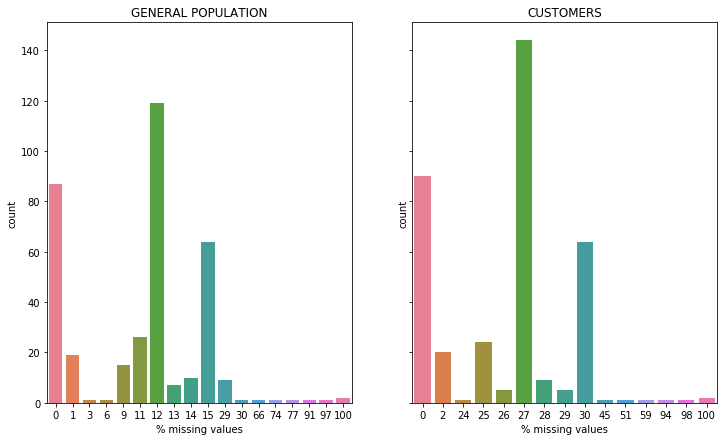

In [30]:
# compare % of missing data between Population and Customer files

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=(12,7))
ax1.set(xlabel = '% missing values', title = 'GENERAL POPULATION')
ax2.set(xlabel = '% missing values', title = 'CUSTOMERS')
sns.countplot(prepare_hist_plot(missing_pop), ax=ax1, palette ='husl')
sns.countplot(prepare_hist_plot(missing_cust), ax=ax2, palette ='husl')
plt.show()

In [31]:
print('popluation total records:' ,azdias.shape[0])
print('customer total records:' ,customers.shape[0])
azdias.shape[0]/customers.shape[0]

popluation total records: 891221
customer total records: 191652


4.650204537390687

### Data Analysis - Summary

* The domain values represent 'unknown' are not consistent between columns. Different values meaning the same thing (ie. 0, -1,9, NaN)
* Volumn of general population file is nearly 5 times larger than that of customer file. This implies 20% of population is Arvato's customers
* Distribution of missing values are slightly difference between General Population and Customer fiels.Around 80+ columns have 0% missing values.Most columns have percentage missing values between 10% and 30%. The MODE % of missing values in Population file is 12%, whereas in Customer file is 27%
* Many columns have identical % of missing values, it is likely that those colums are relevant.
* Only 10% of customers purchase online, 30% are single buyers vs 70% multi buyers
* 8 variables are categorical, the rest are numeric variables.


# DATA PREPARATION


Create generic function to prepare data for machine learning, which includes:
* drop rows with more than 75% missing values
* drop columns with more than 70% missing values
* drop customer id column 
* drop categorical columns
* drop 3 columns exist in Customer file but not exist in Population file
* for numeric variables, replace NaN with values implying 'unknown' in data dictionary, in this case is -1


In [28]:
def drop_columns(df,percent):
    '''
    This function performs below:
    - drop columns with more than input percent
    - drop customer ID column
    - drop categorical columns
    INPUT: input pandas dataframe
    OUTPUT: pandas dataframe after columns being removed
    '''
    # drop columns with more than percent missing values
    #missing_dict = percent_missing_values(df)
    cols = top_percent_missing(df, percent)
    missing_df = df.drop(columns= cols)
    
    # drop customer ID column
    missing_df.drop(['LNR'], axis=1,inplace=True)
    
    # drop categorical columns
    categorical_cols = list(df.select_dtypes(exclude=['int64','float64']).columns)
    dropped_df = missing_df.drop(columns= categorical_cols)
      
    
    return dropped_df

def drop_rows(df,value_threshold):
    '''
    This function drops records with number of Nan greater than threshold
    INPUT: - input pandas dataframe , 
           - threshold of missing values in a row
    OUTPUT: pandas dataframe after rows being removed
    '''
    # drop rows which have more than threshold missing values
    nan_rows =  df.isnull().sum(axis=1)
    droped_rows = list(nan_rows[nan_rows.values >=value_threshold].index)
    dropped_df = df.drop(droped_rows)
    
    return dropped_df

def prepare_data(df,percent_threshold,value_threshold = 0):
    '''
    This function peforms below:
    - drop rows with number of missing values greater than threshold
    - drop columns not useful for machine learning
    - fill NaN values with -1

    INPUT: 
    - input pandas dataframe, 
    - acceptable percentage of missing values (columns with % > threshold will be removed )
    OUTPUT: cleaned pandas dataframe
    '''
    
    # drop rows 
    if value_threshold == 0:  #threshold not supplied, 
        row_df = df  # no row dropped
    else:
        row_df = drop_rows(df,value_threshold)
    
    # drop columns 
    col_df = drop_columns(row_df,percent_threshold)  

    
    # fill NaN with -1 values
    clean_df = col_df.fillna(-1)
    
   
    return clean_df



In [33]:
# check no of missing values in each rows in population file
nan_rows_pop = azdias.shape[1] - azdias.count(axis=1)
nan_rows_pop.describe()

count    891221.000000
mean         37.580940
std          75.290108
min           0.000000
25%           5.000000
50%           6.000000
75%          16.000000
max         259.000000
dtype: float64

In [34]:
# clean population file, remove columns with more than 70% Nan and rows whose NaN counts beyond 3rd ISQ (75%)
pop_cleaned_df = prepare_data(azdias,70,16)

In [35]:
# check no of missing values in each rows in customers file
nan_rows_cust = customers.shape[1] - customers.count(axis=1)
nan_rows_cust.describe()

count    191652.000000
mean         72.342172
std         107.600590
min           0.000000
25%           4.000000
50%           5.000000
75%         225.000000
max         259.000000
dtype: float64

In [36]:
# clean customers file, remove columns with more than 70% Nan and rows whose NaN counts beyond 3rd ISQ (75%)
cust_cleaned_df = prepare_data(customers,70,225)

### Feature Scaling

In [29]:
scaler = StandardScaler()
def scale_numeric_var(df):
    ''' This function scales numeric variables in df dataset
    INPUT:  pandas dataset
    OUTPUT: scaled dataset
    '''

    df_scaled = pd.DataFrame(scaler.fit_transform(df),
                              index=df.index, columns=df.columns)
    
    return df_scaled

In [38]:
# scale population data
df_scaled_pop = scale_numeric_var(pop_cleaned_df)

In [39]:
df_scaled_pop.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,1.439639,-1.738328,1.354278,0.197367,-0.108605,-0.318722,0.152367,0.338563,-0.06061,-0.143883,...,1.349882,0.851338,1.220412,1.577009,-0.412229,0.561856,-0.032174,1.083151,0.963747,-1.694578
2,1.439639,0.688356,0.766289,0.130529,-0.108605,-0.318722,-0.690765,-0.025503,-0.06061,-0.143883,...,-0.311752,1.209617,0.595140,0.136990,-0.412229,0.561856,-1.077273,1.083151,0.963747,0.156128
3,-0.845593,0.117371,0.178300,-0.471015,-0.108605,-0.318722,-1.533897,-0.389569,-0.06061,-1.106970,...,-1.973387,0.493058,0.907776,1.937014,-2.351035,0.561856,1.535475,-0.281641,0.963747,1.081482
4,-0.845593,1.116594,0.325297,-0.337339,-0.108605,-0.318722,1.838631,-0.316756,-0.06061,0.819205,...,-0.311752,-0.940060,-0.655406,-0.583020,-0.896931,0.561856,-0.554723,0.400755,-1.037617,0.156128
5,-0.845593,-0.310867,-0.262692,-0.203662,-0.108605,-0.318722,-0.690765,-0.389569,-0.06061,-1.106970,...,-0.311752,1.567897,-0.030133,-0.583020,1.041875,0.561856,1.535475,0.400755,0.963747,-1.694578


In [40]:
# scale customer data
df_scaled_cust = scale_numeric_var(cust_cleaned_df)
df_scaled_cust.shape

(143206, 356)

### Feature Reduction

In [41]:
pca = PCA()
pca_data = pca.fit(df_scaled_pop)

Text(0,0.5,'% Variance Explained')

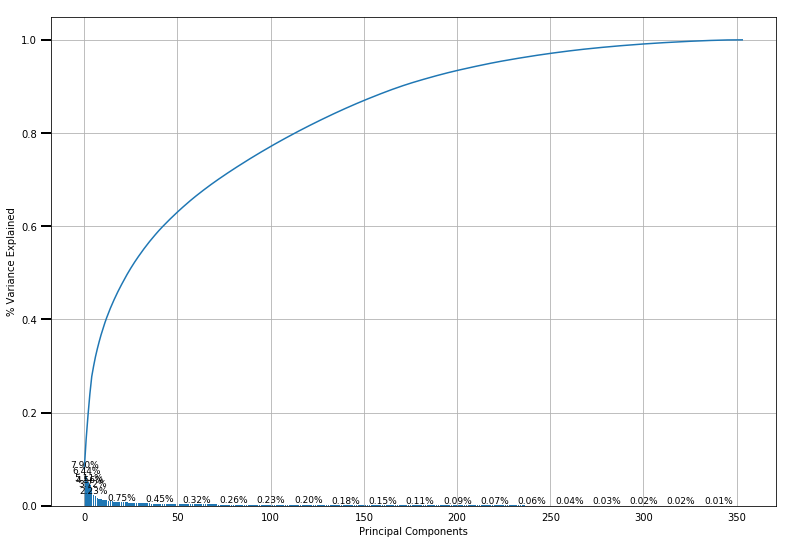

In [42]:
# draw PCA chart

num_components= len(pca.explained_variance_ratio_)
idx = np.arange(num_components)
ratio = pca.explained_variance_ratio_
 
plt.figure(figsize=(13, 9))
ax = plt.subplot(111)
cumvals = np.cumsum(ratio)
ax.bar(idx, ratio)
ax.plot(idx, cumvals)
for i in range(num_components):
    if(i%20 == 0 or i<6):
        ax.annotate(r"%s%%" % ((str(ratio[i]*100)[:4])), (idx[i]+0.2, ratio[i]), va="bottom", ha="center", fontsize=9)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=10, gridOn=True)
 
ax.set_xlabel("Principal Components")
ax.set_ylabel("% Variance Explained")


In [43]:
# Initiate PCA with n =150 and apply to population 
pca = PCA(n_components=150)
pca_pop = pca.fit_transform(df_scaled_pop)


In [44]:
# Display 10 records for the first Principle Component
pca_map = pd.DataFrame({'weight': pca.components_[0],'name': df_scaled_pop.columns})        
pca_map = pca_map.sort_values(by='weight', ascending=False)
pca_map.iloc[:10,:]

,weight,name
302,0.140815,MOBI_REGIO
177,0.134531,KBA13_ANTG1
298,0.132128,LP_STATUS_FEIN
306,0.131347,PLZ8_ANTG1
113,0.129575,KBA05_ANTG1
301,0.128543,MOBI_RASTER
299,0.128305,LP_STATUS_GROB
125,0.124196,KBA05_GBZ
183,0.122876,KBA13_AUTOQUOTE
296,0.111985,LP_LEBENSPHASE_FEIN


In [45]:
# Display 10 records for the second Principle Component
pca_map = pd.DataFrame({'weight': pca.components_[1],'name': df_scaled_pop.columns})        
pca_map = pca_map.sort_values(by='weight', ascending=False)
pca_map.iloc[:10,:]

,weight,name
162,0.193398,KBA05_SEG6
137,0.170830,KBA05_KRSOBER
138,0.168014,KBA05_KRSVAN
139,0.164383,KBA05_KRSZUL
164,0.158197,KBA05_SEG8
136,0.154534,KBA05_KRSKLEIN
163,0.153020,KBA05_SEG7
165,0.152432,KBA05_SEG9
152,0.149607,KBA05_MOD8
154,0.147932,KBA05_MOTOR


In [46]:
# Display 10 records for the third Principle Component
pca_map = pd.DataFrame({'weight': pca.components_[2],'name': df_scaled_pop.columns})        
pca_map = pca_map.sort_values(by='weight', ascending=False)
pca_map.iloc[:10,:]

,weight,name
14,0.160189,CJT_TYP_2
313,0.158473,PRAEGENDE_JUGENDJAHRE
304,0.157425,ONLINE_AFFINITAET
13,0.155169,CJT_TYP_1
93,0.152567,FINANZ_SPARER
40,0.137928,D19_GESAMT_ANZ_24
39,0.129985,D19_GESAMT_ANZ_12
71,0.125300,D19_VERSAND_ANZ_24
94,0.124357,FINANZ_UNAUFFAELLIGER
328,0.123417,SEMIO_PFLICHT


### Find the optimum number of clusters

In [47]:
k_scores = [] 
range_values =  range(1, 12)
for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pca_pop)
  k_scores.append(kmeans.inertia_) 


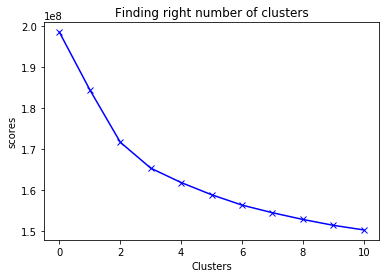

In [48]:
# plot k_scores
plt.plot(k_scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [49]:
i = 0
for k in k_scores:
    print(k-i)
    i = k

198535837.463
-14052598.5938
-12769798.5171
-6323197.83813
-3516018.2864
-2972103.94823
-2530136.78313
-1859238.44136
-1640189.50216
-1425775.99499
-1124546.44107


### Apply Kmeans method on population and customer file

In [50]:
# apply Kmeans with n=5
kmeans = KMeans(5)


In [51]:
# fit clustering model to Population file
clustering_model = kmeans.fit(pca_pop)

In [52]:
# assign clusters to general population and customer
pca_cust = pca.fit_transform(df_scaled_cust)

cluster_pop = clustering_model.predict(pca_pop)
cluster_cust = clustering_model.predict(pca_cust)

# SUMMARY

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [53]:
def create_cluster_df(df):
    '''
    This functions create a dictionary with key is cluster label and value contains % of customers in each cluster
    INPUT: cluster array
    OUTPUT: dictionary contains % of customers in each cluster
    '''
    total_records = len(df)
    cluster_dict = {}
    
    unique, counts = np.unique(df, return_counts=True)

    d = dict(zip(unique, counts))   
    for index, value in d.items():
        cluster_dict[index+1] = round(value/total_records,5)
        
    return cluster_dict

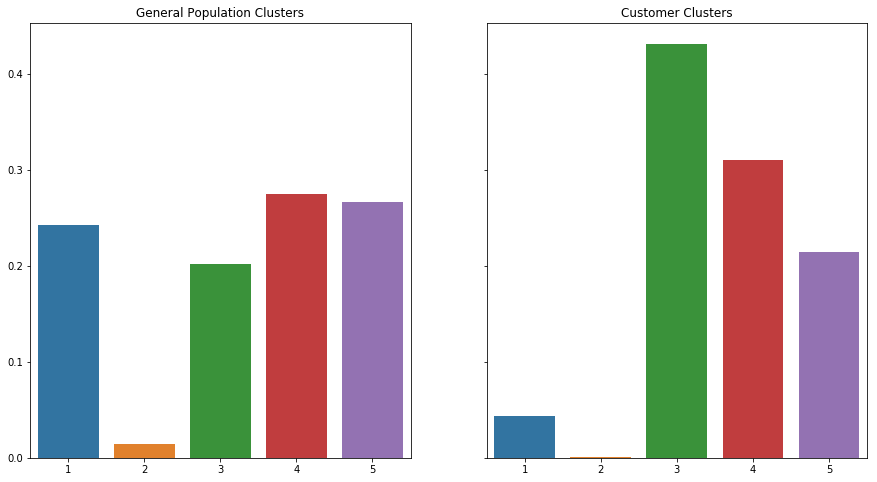

In [54]:
# plot customers and general population clusters

pop_clusters = create_cluster_df(cluster_pop)
cust_clusters = create_cluster_df(cluster_cust)
plt.rcParams["figure.figsize"] = (15,8)
#plt.figure(figsize=(40,30)) 
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1.set_title('General Population Clusters')
ax2.set_title('Customer Clusters')
sns.barplot(x=list(pop_clusters.keys()), y=list(pop_clusters.values()), ax=ax1)
sns.barplot(x=list(cust_clusters.keys()), y=list(cust_clusters.values()), ax=ax2)
plt.show()

In [55]:
print("CLUSTER DISTRIBUTION - GENERAL POPULATION vs CUSTOMERS")
print('-------------------------------------------------------')
for i in range(1,6):
    print("Cluster: {} -  Population: {} - Customer: {}".format(i,pop_clusters[i],cust_clusters[i]))

CLUSTER DISTRIBUTION - GENERAL POPULATION vs CUSTOMERS
-------------------------------------------------------
Cluster: 1 -  Population: 0.24236 - Customer: 0.04318
Cluster: 2 -  Population: 0.01411 - Customer: 0.00038
Cluster: 3 -  Population: 0.20243 - Customer: 0.43158
Cluster: 4 -  Population: 0.27461 - Customer: 0.31055
Cluster: 5 -  Population: 0.26649 - Customer: 0.21431


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [10]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [12]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


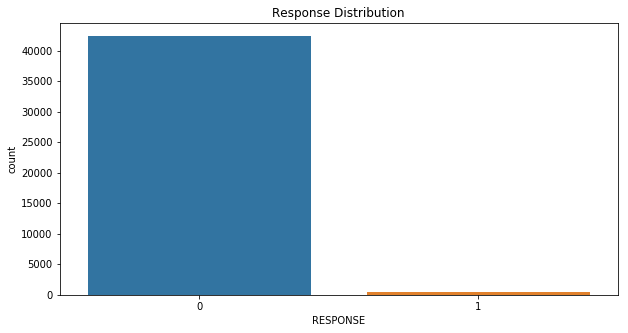

In [14]:
# display response distribution

response = mailout_train['RESPONSE']
unique, counts = np.unique(response, return_counts=True)
plt.rcParams["figure.figsize"] = (10,5)

ax = sns.countplot(x=response.index, data=response)

ax.set_title('Response Distribution')
plt.show()

In [15]:
unique, counts = np.unique(response, return_counts=True)
print('Response: {}  Count: {}'.format(unique,counts))
print('Response: {}  Percent: {}'.format(unique,counts/len(mailout_train['RESPONSE'])))


Response: [0 1]  Count: [42430   532]
Response: [0 1]  Percent: [ 0.98761696  0.01238304]


In [16]:
# calculate response1:response0 ratio
response_0 = len(response) / (2 * counts[0])
response_1 = len(response) / (2 * counts[1])
weights = {0:response_0,1:response_1}  # this will be used as a parameter of the model creation
print(weights)

{0: 0.50626914918689603, 1: 40.377819548872182}


### Data Preparation

In [30]:
# this step remove columns with more than 70% NaN and fill NaN
train_df = prepare_data(mailout_train,70)
test_df = prepare_data(mailout_test,70)

In [31]:
train_Y = train_df['RESPONSE']
train_Y[0:5]
unique, counts = np.unique(train_Y, return_counts=True)
print(unique,counts)

[0 1] [42430   532]


In [32]:
train_df = train_df.drop(['RESPONSE'], axis=1)


In [33]:
#Split train df to  train_X, train_Y
train_X = scale_numeric_var(train_df)

In [34]:
# scale test data
test_X = scale_numeric_var(test_df)

## Build base models

Below 4 models will be built:
* Random Forest Classification 
* Logistis Regression 
* Support Vector Classification  
* Decision Tree Classification 

In [35]:
# import model libraries and roc_auc score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score

In [316]:
# initiate models
model_rfc = RandomForestClassifier(class_weight=weights)
model_lr = LogisticRegression(class_weight=weights)  #class_weight=weights
model_dtc = DecisionTreeClassifier(class_weight=weights)
model_gbc = GradientBoostingClassifier()

In [317]:
# fit models
model_rfc.fit(train_X,train_Y)
model_lr.fit(train_X,train_Y)
model_dtc.fit(train_X,train_Y)
model_gbc.fit(train_X,train_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [318]:
# model prediction
y_pred_rfc = model_rfc.predict(train_X)
y_pred_lr = model_lr.predict(train_X)
y_pred_dtc = model_dtc.predict(train_X)
y_pred_gbc = model_gbc.predict(train_X)

In [319]:
# print AUC scores
print('RandomForest:',roc_auc_score(y_pred_rfc , train_Y))
print('LogisticRegression:',roc_auc_score(y_pred_lr , train_Y))
print('DecisionTree:',roc_auc_score(y_pred_dtc , train_Y))
print('GradientBoosting:',roc_auc_score(y_pred_gbc , train_Y)) # all 99% without weights

RandomForest: 0.637591506168
LogisticRegression: 0.514274113215
DecisionTree: 0.666593192736
GradientBoosting: 0.994015461997


## Model Evaluation and Validation

Given the AUC ROC traing score in precious section. I picked GradientBoostingClassifier to explore and further fine tuning
The approach for GradientBoostingClassifier evaluation and validation below:<br>

1)	validate base model using StratifiedKfold (5) validation <br>
2)	fine tune hyperparameters using GridSearchCV<br>
3)	retrain the model using best parameters from step above<br>
4)	apply StratifiedKfold validation on tuned model<br>
5)	compare validation before and after tuning.<br>

The hyperparameters using for GridSearchCV below:<br>
param_grid = {<br>
  'learning_rate: [0.05, 0.1, 0.15 ],<br>
  'max_depth':[3,5,8],<br>
  'n_estimators':['50,100,150],<br>
  'max_features':['log2','sqrt'] }<br>


## Validate GBC base model using KFold

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
skf.get_n_splits(train_X, train_Y)

5

In [320]:
model_gbc = GradientBoostingClassifier()
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)

In [322]:
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

average validation score:  0.760420199806
fold scores: [ 0.76216462  0.7338073   0.80550263  0.75464861  0.74597784]


## Tune, retrain and validate GBC model after tuning

The GridSearchCV is painful, it took forever to complete so I killed the process and manually tuning hyperparameters on by one. See codes in markdowns <br>
The parameters that give the best validation scores when experimenting difference hyperparameter values are:<br>

learning_rate = 0.05 <br>
max_depth = 3 <br>
n_estimators = 50 <br>
max_features = none <br>

I will retrain the model using hyperparameters above. The validation scores below:


In [37]:
model_gbc = GradientBoostingClassifier(learning_rate = 0.05,max_depth = 3,n_estimators = 50,max_features = None)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

average validation score:  0.768474574884
fold scores: [ 0.75512554  0.75502312  0.8132807   0.76640271  0.75254081]


model_gbc = GradientBoostingClassifier(learning_rate=0.05)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(learning_rate=0.15)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(max_depth=5)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(max_depth=8)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(n_estimators=50)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(n_estimators=150)
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(max_features='log2')
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

model_gbc = GradientBoostingClassifier(max_features='sqrt')
cv_results = cross_val_score(model_gbc, train_X, train_Y, cv=skf, scoring='roc_auc', n_jobs=-1)
print('average validation score: ',sum(cv_results)/len(cv_results))
print('fold scores:', cv_results)

## MODEL DEPLOYMENT

In [39]:
# predict response for mailout_test
model_gbc.fit(train_X,train_Y)
response_pred  = model_gbc.predict(test_X)

In [40]:
# predict response probability for mailout_test
response_probas = model_gbc.predict_proba(test_X)
    

In [41]:
# merge model prediction results with mailout_test
predictions = pd.Series(data=response_pred, index=test_X.index, name='predicted_response')
probabilities = pd.DataFrame(data=response_probas, index=test_X.index, columns=['prob_0','RESPONSE'])

results_test = mailout_test.join(predictions, how='left')
results_test = results_test.join(probabilities, how='left')

In [42]:
results_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,predicted_response,prob_0,RESPONSE
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,3.0,6.0,9.0,3.0,3,1,4,0,0.966813,0.033187
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,6.0,9.0,5.0,3,1,4,0,0.972089,0.027911
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,2.0,9.0,4.0,3,2,4,0,0.995047,0.004953
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,NaN,9.0,2.0,3,2,4,0,0.994756,0.005244
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,3.0,9.0,7.0,4,2,4,0,0.994226,0.005774


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### PREPARE CSV FILE FOR KAGGLE COMPETITION

In [43]:
results_test['RESPONSE'].value_counts()

0.011648    3131
0.011061    2813
0.010607     179
0.011170     166
0.011293     156
0.011521     140
0.010724     114
0.004015      60
0.004684      56
0.012163      55
0.011077      55
0.004605      49
0.004633      46
0.004555      41
0.004059      39
0.011665      32
0.012031      28
0.029572      26
0.033464      26
0.003895      25
0.010941      24
0.011199      24
0.011793      23
0.004342      23
0.004494      21
0.029597      21
0.004844      21
0.004716      21
0.027439      19
0.004152      18
            ... 
0.045199       1
0.030906       1
0.004690       1
0.004835       1
0.005124       1
0.020027       1
0.003971       1
0.003736       1
0.005211       1
0.031071       1
0.006644       1
0.004196       1
0.005754       1
0.003990       1
0.005276       1
0.029068       1
0.004479       1
0.004276       1
0.003752       1
0.004359       1
0.004758       1
0.005564       1
0.036094       1
0.027859       1
0.004713       1
0.005664       1
0.003804       1
0.005560      

In [44]:
mailout_response = results_test[['LNR','RESPONSE']]

In [45]:
mailout_response.set_index('LNR', inplace = True)

In [46]:
# Create CSV file for Kaggle Competition
mailout_response.to_csv('avrvato_response.csv')